In [26]:
# by Joh Schöneberg 2018

%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from numpy import genfromtxt


import pandas as pd

from mpl_toolkits import mplot3d
#%matplotlib notebook

#own modules / functions
import sys

sys.path.append("./modules")
import TiffProcessing as tiffproc
import InputProcessing as inproc
sys.path.append("./classes")
import Track

In [28]:
inputParameters = pd.read_csv('../../input/_inputParameters.csv',names=['key','value'])
inputParameters

,key,value
0,inputDataFolder,/Users/johannesschoeneberg/git/pyLattice/inpu...
1,outputDataFolder,//Users/johannesschoeneberg/git/pyLattice/inp...
2,movieLength,70
3,allowedMaxNumDetectionsPerFrame,3000
4,framerate_msec,5689
5,detectionFilename,Detection3D.mat
6,trackingFilename,trackedFeatures.mat
7,trackingCsvFilename,trackedFeatures.csv
8,trackingFilenameProcessed,trackedFeaturesProcessed.mat
9,trackingCsvFilenameProcessed,trackedFeaturesProcessed.csv


In [61]:
inputParameters = pd.read_csv('../../input/_inputParameters.csv',names=['key','value'])


inputDataFolder = inproc.getInputParameter(inputParameters,"inputDataFolder")
outputDataFolder = inproc.getInputParameter(inputParameters,"outputDataFolder")

trackingCsvFilename = inproc.getInputParameter(inputParameters,"trackingCsvFilename")
trackingCsvFilenameProcessed = inproc.getInputParameter(inputParameters,"trackingCsvFilenameProcessed")

slave_outputDataFolder  = inproc.getInputParameter(inputParameters,"slave_outputDataFolder")
master_outputDataFolder  = inproc.getInputParameter(inputParameters,"master_outputDataFolder")

slave_uniqueFilenameString = inproc.getInputParameter(inputParameters,"slave_uniqueFilenameString")
master_uniqueFilenameString = inproc.getInputParameter(inputParameters,"master_uniqueFilenameString")


slave_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"slave_trackingProcessedBildFilename")
master_trackingProcessedBildFilename = inproc.getInputParameter(inputParameters,"master_trackingProcessedBildFilename")



framerate_msec = float(inproc.getInputParameter(inputParameters,"framerate_msec"))
movieLength = int(inproc.getInputParameter(inputParameters,"movieLength"))


In [73]:
# read the raw csv data for further processing

path = outputDataFolder+'/'+trackingCsvFilenameProcessed
print(path)

data = pd.read_csv(path,header=0)
data.columns = ["trackId","tracklength","time[s]","frameId","lifetime","catIdx","m_x",'m_y',"m_z","m_A","m_c","m_pval_Ar","s_x",'s_y',"s_z","s_A","s_c","s_pval_Ar"]
trackIds = data.drop_duplicates(subset='trackId')['trackId'].values

data[0:5]



//Users/johannesschoeneberg/git/pyLattice/input/imaging_data/output/trackedFeaturesProcessed.csv


,trackId,tracklength,time[s],frameId,lifetime,catIdx,m_x,m_y,m_z,m_A,m_c,m_pval_Ar,s_x,s_y,s_z,s_A,s_c,s_pval_Ar
0,1,83,0,1,398.23,8,7.904661e+01,6.464731e+01,8.131298e+01,2.380362e+04,5.097926e+03,0,7.861783e+01,6.335770e+01,8.131298e+01,1.455107e+04,1.618403e+04,9.994436e-01
1,1,83,5.689000e+00,2,398.23,8,7.850739e+01,6.542015e+01,8.129176e+01,2.104784e+04,5.305183e+03,0,7.755419e+01,6.464906e+01,8.129176e+01,1.635423e+04,1.955088e+04,7.208670e-21
2,1,83,1.137800e+01,3,398.23,8,7.839408e+01,6.518394e+01,8.116666e+01,2.085433e+04,5.234626e+03,0,7.735373e+01,6.428964e+01,8.116666e+01,7.358672e+03,1.554692e+04,1
3,1,83,1.706700e+01,4,398.23,8,7.802180e+01,6.560145e+01,8.168228e+01,2.318226e+04,6.263921e+03,0,7.704685e+01,6.395467e+01,8.168228e+01,9.978225e+03,1.407360e+04,1
4,1,83,2.275600e+01,5,398.23,8,7.721728e+01,6.629176e+01,8.136034e+01,2.259943e+04,5.388422e+03,0,7.959930e+01,6.657997e+01,8.136034e+01,1.417622e+04,1.468696e+04,3.412941e-172


cat_Ia_Tracks 182
allTracks 1440


Text(0.5,0,'z [px]')

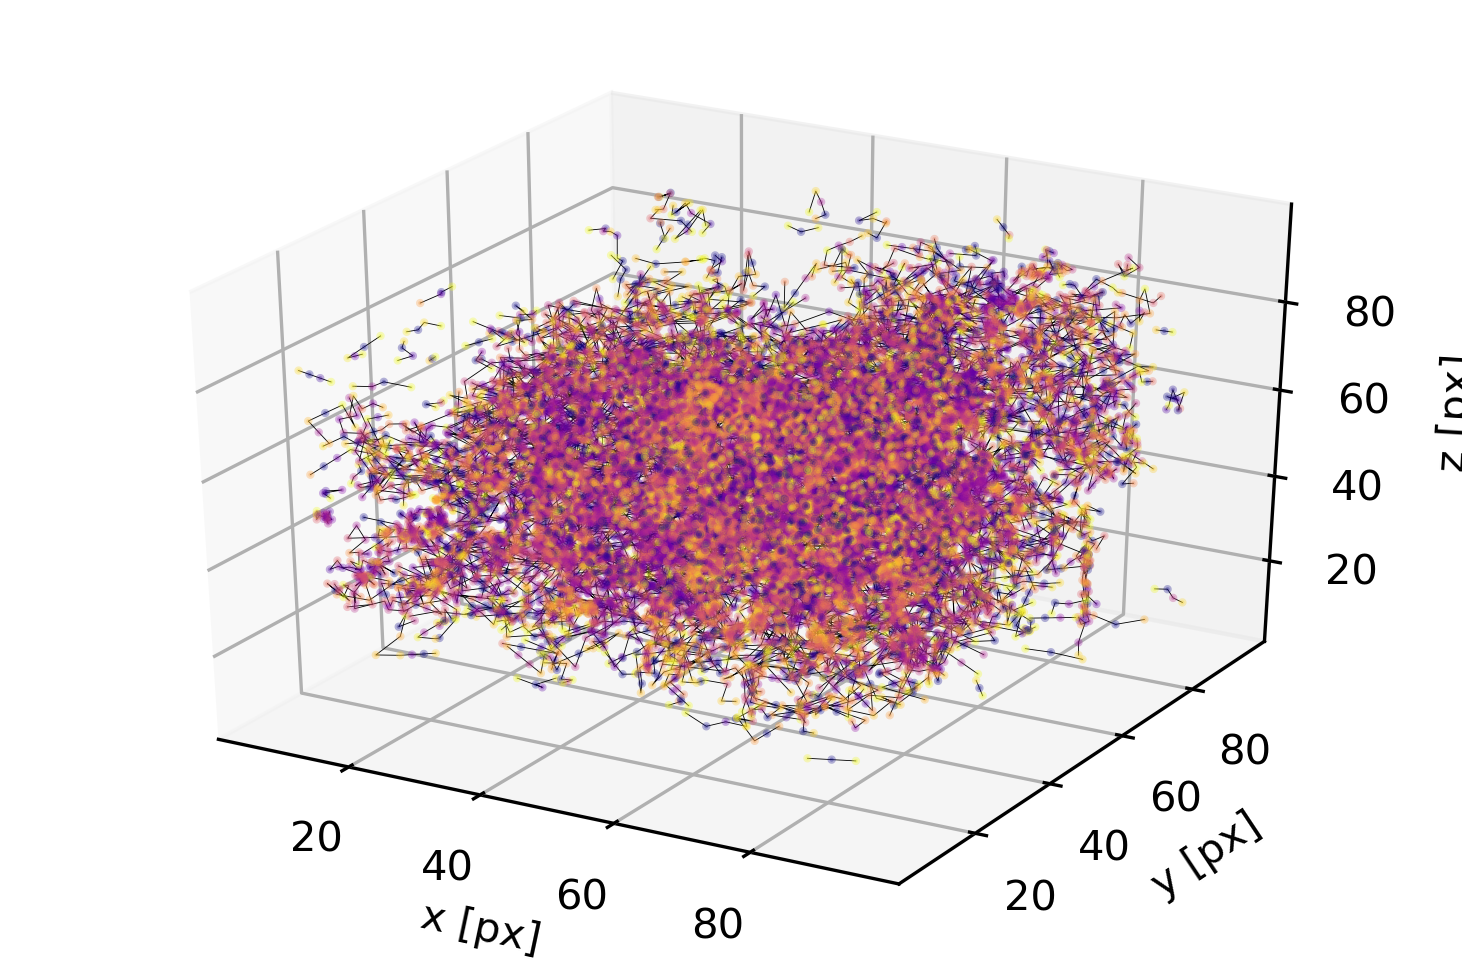

In [79]:
#plot them all

#%----------------------------------------------------------------------------
#    % I. Assign category to each track
#    %----------------------------------------------------------------------------
#    % Categories:
#    % Ia)  Single tracks with valid gaps
#    % Ib)  Single tracks with invalid gaps
#    % Ic)  Single tracks cut at beginning or end
#    % Id)  Single tracks, persistent
#    % IIa) Compound tracks with valid gaps
#    % IIb) Compound tracks with invalid gaps
#    % IIc) Compound tracks cut at beginning or end
#    % IId) Compound tracks, persistent
#    
#    % The categories correspond to index 1-8, in the above order


longtracks = data[data['tracklength'] >= 3]
d = longtracks




allTracks = np.unique(d['trackId'].values)
cat_Ia_Tracks = np.unique(d[d['catIdx'] == 1]['trackId'])
cat_Ib_Tracks = np.unique(d[d['catIdx'] == 2]['trackId'])
cat_Ic_Tracks = np.unique(d[d['catIdx'] == 3]['trackId'])
cat_Id_Tracks = np.unique(d[d['catIdx'] == 4]['trackId'])
cat_IIa_Tracks = np.unique(d[d['catIdx'] == 5]['trackId'])
cat_IIb_Tracks = np.unique(d[d['catIdx'] == 6]['trackId'])
cat_IIc_Tracks = np.unique(d[d['catIdx'] == 7]['trackId'])
cat_IId_Tracks = np.unique(d[d['catIdx'] == 8]['trackId'])

print("cat_Ia_Tracks",len(cat_Ia_Tracks))
print("allTracks",len(allTracks))

tracksToDisplay = allTracks

plt.figure(dpi=300)
ax = plt.axes(projection='3d')

for trackID in tracksToDisplay:
    
    
    track = data[data['trackId'] == trackID]

    # Data for a three-dimensional line
    x = track['m_x'].values.astype(float)
    y = track['m_y'].values.astype(float)
    z = track['m_z'].values.astype(float)
    intensity = track['m_A'].values.astype(float)
    ax.plot3D(x, y, z, 'k',lw=0.2)
    ax.scatter3D(x, y, z, c=intensity, cmap='plasma',s=1,alpha=0.3);

ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax.set_zlabel('z [px]')